## Библиотеки

In [383]:
!pip install -q fuzzywuzzy python-Levenshtein

In [384]:
pip install easyocr

## Распознавание

In [385]:
import cv2
import easyocr
import numpy as np
import pandas as pd
from pathlib import Path
from fuzzywuzzy import fuzz
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [386]:
reader = easyocr.Reader(['en'])

In [387]:
base_path = Path('/content/drive/MyDrive/УИИ/Стажировки/NetOptic/attributes/')
ann_path = base_path / 'attributes.csv'
img_path = base_path / 'images'

#### Функции

In [388]:
def gammaCorrection(img, gamma, **kwargs):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(img, table)

In [389]:
def preprocc(img, size=(640, 960), pad=20, version=1, **kwargs):
  img = cv2.resize(img, size)

  # crop image
  imgC = cv2.Canny(img, 100, 200)
  a, *_, b = np.where(imgC > 0)[0]
  img = img[max(a-pad, 0):min(b+pad, img.shape[0]), ...]

  match version:
    case 1: # v1
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.convertScaleAbs(img, 2)
    case 2: # v2
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      _, img = cv2.threshold(img, 0, 255,
                             cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    case 3: # v3
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img = gammaCorrection(img, **kwargs)

  return img

In [390]:
def draw_detections(img, detections, color = (255, 0, 0), fontScale = 0.4):
  font = cv2.FONT_HERSHEY_SIMPLEX
  for det in detections:
    bbox, text, conf = det
    bbox = [list(map(int, p)) for p in bbox]
    img = cv2.rectangle(img, bbox[0], bbox[2], color=color)

    text = f'{text} {conf:.2f}'
    img = cv2.putText(img, text, bbox[0],
                      font, fontScale, color)
  return img

In [391]:
def joined_text(detections, min_score=0.5, **kwargs):
  dets = sorted([val for val in detections if val[-1] > min_score],
                key=lambda x: x[0][0])
  return ' '.join([det[1] for det in dets])

In [392]:
def find_text(img, reader, preprocc=None, **kwargs):
  img = preprocc(img, **kwargs) if preprocc else img
  detections = reader.readtext(img)
  text = joined_text(detections, **kwargs)
  return text

#### Attributes

In [393]:
ann_data = pd.read_csv(ann_path)
# drop empty lines
ann_data = ann_data.dropna(how='all', subset=ann_data.columns[1:])
columns = ['lens_width', 'nose_bridge', 'temple_length', 'frame_width']
ann_data[columns]=ann_data[columns].fillna(0).astype('int')
ann_data

,id,text,model,lens_width,nose_bridge,temple_length,frame_width
0,1,RB 4246V 5240 47*19 140,RB 4246V 5240,47,19,140,113
1,2,RB 5353 5628 50*19 145,RB 5353 5628,50,19,145,119
2,3,RB 3747V 2500 47*21 140,RB 3747V 2500,47,21,140,115
3,4,RB 7084 5635 54*18 140,RB 7084 5635,54,18,140,126
4,5,RB 7086 2000 51*18 140,RB 7086 2000,51,18,140,120
...,...,...,...,...,...,...,...
111,113,VYFLI039 BPL 55*16 145,YFLI039 BPL,55,16,145,0
112,114,VYF154 C02 54*18 140,VYF154 C02,54,18,140,0
113,115,VY 16 Col.04 53*14 135,VY 16 Col.04,53,14,135,0
114,116,VYF120 C02 55*18 140,VYF120 C02,55,18,140,0


#### Images

In [394]:
img_by_category = []
for i in img_path.glob('**/*.jpg'):
  if i.parent.stem != 'orig':
    path = i.relative_to(img_path)
    img_by_category.append((int(path.stem), path, path.parent.stem))
img_by_category = pd.DataFrame(data=img_by_category,
                               columns=['id', 'path', 'category'])
img_by_category

,id,path,category
0,106,hard/106.jpg,hard
1,114,hard/114.jpg,hard
2,109,hard/109.jpg,hard
3,108,hard/108.jpg,hard
4,88,hard/88.jpg,hard
...,...,...,...
111,65,bad/65.jpg,bad
112,66,bad/66.jpg,bad
113,23,bad/23.jpg,bad
114,21,bad/21.jpg,bad


In [395]:
df = pd.merge(ann_data, img_by_category, on='id')
df

,id,text,model,lens_width,nose_bridge,temple_length,frame_width,path,category
0,1,RB 4246V 5240 47*19 140,RB 4246V 5240,47,19,140,113,normal/1.jpg,normal
1,2,RB 5353 5628 50*19 145,RB 5353 5628,50,19,145,119,normal/2.jpg,normal
2,3,RB 3747V 2500 47*21 140,RB 3747V 2500,47,21,140,115,normal/3.jpg,normal
3,4,RB 7084 5635 54*18 140,RB 7084 5635,54,18,140,126,normal/4.jpg,normal
4,5,RB 7086 2000 51*18 140,RB 7086 2000,51,18,140,120,normal/5.jpg,normal
...,...,...,...,...,...,...,...,...,...
111,113,VYFLI039 BPL 55*16 145,YFLI039 BPL,55,16,145,0,normal/113.jpg,normal
112,114,VYF154 C02 54*18 140,VYF154 C02,54,18,140,0,hard/114.jpg,hard
113,115,VY 16 Col.04 53*14 135,VY 16 Col.04,53,14,135,0,normal/115.jpg,normal
114,116,VYF120 C02 55*18 140,VYF120 C02,55,18,140,0,normal/116.jpg,normal


In [396]:
for row in tqdm(range(len(df))):
  path = df.loc[row, 'path']
  img = cv2.imread(str(img_path / path))
  df.loc[row, 'found_text'] = find_text(img, reader, preprocc, gamma=2.2, min_score=0.0)
  df.loc[row, 'score'] = fuzz.ratio(df.loc[row, 'text'], df.loc[row, 'found_text'])


  0%|          | 0/116 [00:00<?, ?it/s]

In [397]:
df.groupby(by='category').score.describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
bad,9.0,64.555556,26.557066,26.0,39.00,72.0,84.0,91.0
hard,24.0,73.541667,23.247214,14.0,71.75,80.5,88.5,95.0
normal,83.0,87.578313,10.205355,19.0,84.50,90.0,93.0,96.0


In [403]:
df[(df.category=='normal') & (df.score == 19)]

,id,text,model,lens_width,nose_bridge,temple_length,frame_width,path,category,found_text,score
74,75,HMO-268 52*16 145 C03,HMO-268 C03,52,18,145,0,normal/75.jpg,normal,HhozDIN Cud,19.0


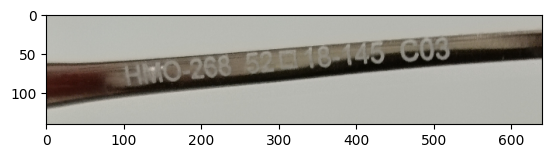

In [404]:
row = 74
path = df.loc[row, 'path']
img = cv2.imread(str(img_path / path))
img = preprocc(img, gamma=2.5)
plt.imshow(img, cmap='gray')
plt.show()

In [405]:
joined_text(reader.readtext(img), min_score=0)

'HhozDIN Cud'